In [1]:
# Cell 1 Imports and setup
!pip install -q "scikit-learn==1.4.2" "xgboost==1.7.6" ujson openpyxl joblib
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import re
from collections import Counter


plt.rcParams["figure.figsize"] = (6, 4) 


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Cell 2: Clean data, load data and analysis

df = pd.read_csv("cve_data_with_epss.csv")
print(f"✅ Successfully loaded merged data: {len(df):,} records")
print(f"📊 Data shape: {df.shape[0]} rows × {df.shape[1]} columns")

if 'Attempted Exploitation' in df.columns:
    df['Attempted Exploitation'] = df['Attempted Exploitation'].str.strip().str.lower()  
print(f"\n{'='*80}")
print("📋 DATASET OVERVIEW")
print(f"{'='*80}")

print(f"📋 Columns ({len(df.columns)} total):")
for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    missing = df[col].isna().sum()
    missing_pct = (missing / len(df)) * 100
    print(f"  {i:2d}. {col:<25} | {dtype:<10} | {missing:3d} missing ({missing_pct:5.1f}%)")


print(f"\n{'='*80}")
print("📈 DATA QUALITY SUMMARY")
print(f"{'='*80}")

total_cells = len(df) * len(df.columns)
missing_cells = df.isnull().sum().sum()
completeness = ((total_cells - missing_cells) / total_cells) * 100

print(f"📊 Overall data completeness: {completeness:.1f}%")
print(f"📊 Records with complete data: {len(df.dropna())} ({(len(df.dropna()) / len(df)) * 100:.1f}%)")
print(f"📊 Records with any missing data: {len(df) - len(df.dropna())} ({((len(df) - len(df.dropna())) / len(df)) * 100:.1f}%)")


print(f"\n{'='*80}")
print("🎯 EPSS SCORE ANALYSIS")
print(f"{'='*80}")

if 'EPSS score' in df.columns:
    epss_available = df['EPSS score'].notna().sum()
    epss_missing = df['EPSS score'].isna().sum()
    epss_completeness = (epss_available / len(df)) * 100
    
    print(f"📊 EPSS scores available: {epss_available:,} ({epss_completeness:.1f}%)")
    print(f"📊 EPSS scores missing: {epss_missing:,} ({(epss_missing / len(df)) * 100:.1f}%)")
    
    if epss_available > 0:
        epss_stats = df['EPSS score'].describe()
        print(f"\n📈 EPSS Score Statistics:")
        print(f"  Mean:     {epss_stats['mean']:.6f}")
        print(f"  Median:   {epss_stats['50%']:.6f}")
        print(f"  Std Dev:  {epss_stats['std']:.6f}")
        print(f"  Min:      {epss_stats['min']:.6f}")
        print(f"  Max:      {epss_stats['max']:.6f}")
        print(f"  Q1 (25%): {epss_stats['25%']:.6f}")
        print(f"  Q3 (75%): {epss_stats['75%']:.6f}")
        
        low_risk = (df['EPSS score'] < 0.01).sum()
        medium_risk = ((df['EPSS score'] >= 0.01) & (df['EPSS score'] < 0.1)).sum()
        high_risk = (df['EPSS score'] >= 0.1).sum()
        
        print(f"\n🎯 EPSS Risk Distribution:")
        print(f"  Low risk (<0.01):     {low_risk:,} ({(low_risk/epss_available)*100:.1f}%)")
        print(f"  Medium risk (0.01-0.1): {medium_risk:,} ({(medium_risk/epss_available)*100:.1f}%)")
        print(f"  High risk (≥0.1):      {high_risk:,} ({(high_risk/epss_available)*100:.1f}%)")

print(f"\n{'='*80}")
print("🛡️ CVSS SCORE ANALYSIS")
print(f"{'='*80}")

if 'CVSS v3.1 Score' in df.columns:
    cvss_available = df['CVSS v3.1 Score'].notna().sum()
    cvss_missing = df['CVSS v3.1 Score'].isna().sum()
    cvss_completeness = (cvss_available / len(df)) * 100
    
    print(f"📊 CVSS scores available: {cvss_available:,} ({cvss_completeness:.1f}%)")
    print(f"📊 CVSS scores missing: {cvss_missing:,} ({(cvss_missing / len(df)) * 100:.1f}%)")
    
    if cvss_available > 0:
        cvss_stats = df['CVSS v3.1 Score'].describe()
        print(f"\n📈 CVSS Score Statistics:")
        print(f"  Mean:     {cvss_stats['mean']:.2f}")
        print(f"  Median:   {cvss_stats['50%']:.2f}")
        print(f"  Std Dev:  {cvss_stats['std']:.2f}")
        print(f"  Min:      {cvss_stats['min']:.2f}")
        print(f"  Max:      {cvss_stats['max']:.2f}")
        
        low_cvss = (df['CVSS v3.1 Score'] < 4).sum()
        medium_cvss = ((df['CVSS v3.1 Score'] >= 4) & (df['CVSS v3.1 Score'] < 7)).sum()
        high_cvss = ((df['CVSS v3.1 Score'] >= 7) & (df['CVSS v3.1 Score'] < 9)).sum()
        critical_cvss = (df['CVSS v3.1 Score'] >= 9).sum()
        
        print(f"\n🛡️ CVSS Severity Distribution:")
        print(f"  Low (0-3.9):      {low_cvss:,} ({(low_cvss/cvss_available)*100:.1f}%)")
        print(f"  Medium (4-6.9):    {medium_cvss:,} ({(medium_cvss/cvss_available)*100:.1f}%)")
        print(f"  High (7-8.9):      {high_cvss:,} ({(high_cvss/cvss_available)*100:.1f}%)")
        print(f"  Critical (9-10):   {critical_cvss:,} ({(critical_cvss/cvss_available)*100:.1f}%)")

print(f"\n{'='*80}")
print("💥 EXPLOITATION ANALYSIS")
print(f"{'='*80}")

if 'Attempted Exploitation' in df.columns:
    exploitation_counts = df['Attempted Exploitation'].value_counts()
    total_exploitation = df['Attempted Exploitation'].notna().sum()
    
    print(f"📊 Exploitation data available: {total_exploitation:,} ({(total_exploitation/len(df))*100:.1f}%)")
    
    if len(exploitation_counts) > 0:
        print(f"\n💥 Exploitation Status:")
        for status, count in exploitation_counts.items():
            percentage = (count / total_exploitation) * 100
            print(f"  {status}: {count:,} ({(count/total_exploitation)*100:.1f}%)")
        
        exploited_count = exploitation_counts.get('yes', 0)
        not_exploited_count = exploitation_counts.get('no', 0)
        
        print(f"\n🎯 Exploitation Summary:")
        print(f"  Exploited CVEs:     {exploited_count:,} ({(exploited_count/total_exploitation)*100:.1f}%)")
        print(f"  Not exploited CVEs: {not_exploited_count:,} ({(not_exploited_count/total_exploitation)*100:.1f}%)")
        print(f"  Exploitation ratio: {exploited_count/(exploited_count+not_exploited_count)*100:.1f}%")

print(f"\n{'='*80}")
print("📋 SAMPLE DATA (First 5 Records)")
print(f"{'='*80}")

key_cols = ['CVE ID', 'CVSS v3.1 Score', 'EPSS score', 'Vendor', 'Attempted Exploitation']
display_cols = [col for col in key_cols if col in df.columns]

sample_data = df[display_cols].head(5).copy()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

print(sample_data.to_string(index=False))

pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print(f"\n{'='*80}")
print("✅ DATA LOADING COMPLETE - READY FOR MODELING")
print(f"{'='*80}")
print(f"📊 Dataset: {len(df):,} records with {len(df.columns)} features")
print(f"🎯 Target variable: EPSS score ({epss_available:,} available)")
print(f"🛡️ Key features: CVSS score, Vendor, Product, Description, etc.")
print(f"💡 Next step: Run cell 5 for feature engineering")


✅ Successfully loaded merged data: 503 records
📊 Data shape: 503 rows × 12 columns

📋 DATASET OVERVIEW
📋 Columns (12 total):
   1. CVE ID                    | object     |   0 missing (  0.0%)
   2. Title                     | object     | 115 missing ( 22.9%)
   3. Description               | object     |  26 missing (  5.2%)
   4. CVSS v3.1 Score           | float64    | 143 missing ( 28.4%)
   5. Vendor                    | object     | 107 missing ( 21.3%)
   6. Product                   | object     | 105 missing ( 20.9%)
   7. datePublished             | object     |  14 missing (  2.8%)
   8. Attempted Exploitation    | object     |  16 missing (  3.2%)
   9. Reference                 | float64    |  16 missing (  3.2%)
  10. CWE                       | object     |  16 missing (  3.2%)
  11. CWE-N                     | float64    |  16 missing (  3.2%)
  12. EPSS score                | float64    |  15 missing (  3.0%)

📈 DATA QUALITY SUMMARY
📊 Overall data completeness: 90.2%


In [3]:
# Cell 3: preprocessing & feature engineering
RANDOM_STATE = 42

cat_cols = ["Vendor", "Product", "Attempted Exploitation", "CWE"]
cat_cols = [col for col in cat_cols if col in df.columns]
df[cat_cols] = df[cat_cols].fillna("missing").astype(str)

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df[cat_cols] = enc.fit_transform(df[cat_cols])

df["datePublished"] = pd.to_datetime(df["datePublished"], errors="coerce")
if df["datePublished"].dt.tz is not None:
    df["datePublished"] = df["datePublished"].dt.tz_localize(None)

df["Year"]  = df["datePublished"].dt.year.fillna(0).astype(int)
df["Month"] = df["datePublished"].dt.month.fillna(0).astype(int)
df["DayOfYear"] = df["datePublished"].dt.dayofyear.fillna(0).astype(int)

def extract_text_features(text):
    """Extract features from text descriptions."""
    if pd.isna(text) or text == "":
        return {
            "text_length": 0,
            "word_count": 0,
            "avg_word_length": 0,
            "has_exploit_keywords": 0,
            "has_vulnerability_keywords": 0
        }
    
    text = str(text).lower()
    words = re.findall(r'\b\w+\b', text)
    
    exploit_keywords = ['exploit', 'attack', 'hack', 'breach', 'compromise', 'malware', 'virus']
    vulnerability_keywords = ['vulnerability', 'weakness', 'flaw', 'bug', 'defect', 'issue']
    
    return {
        "text_length": len(text),
        "word_count": len(words),
        "avg_word_length": np.mean([len(w) for w in words]) if words else 0,
        "has_exploit_keywords": int(any(kw in text for kw in exploit_keywords)),
        "has_vulnerability_keywords": int(any(kw in text for kw in vulnerability_keywords))
    }

if "Description" in df.columns:
    text_features = df["Description"].apply(extract_text_features)
    for feature in ["text_length", "word_count", "avg_word_length", "has_exploit_keywords", "has_vulnerability_keywords"]:
        df[f"desc_{feature}"] = text_features.apply(lambda x: x[feature])
else:
    for feature in ["text_length", "word_count", "avg_word_length", "has_exploit_keywords", "has_vulnerability_keywords"]:
        df[f"desc_{feature}"] = 0
    print("Warning: 'Description' column not found, using default text features")

if "Title" in df.columns:
    title_features = df["Title"].apply(extract_text_features)
    for feature in ["text_length", "word_count", "avg_word_length", "has_exploit_keywords", "has_vulnerability_keywords"]:
        df[f"title_{feature}"] = title_features.apply(lambda x: x[feature])
else:
    for feature in ["text_length", "word_count", "avg_word_length", "has_exploit_keywords", "has_vulnerability_keywords"]:
        df[f"title_{feature}"] = 0
    print("Warning: 'Title' column not found, using default title features")

if "Vendor" in df.columns and "Product" in df.columns:
    df["vendor_product"] = df["Vendor"].astype(str) + "_" + df["Product"].astype(str)
    vendor_product_counts = df["vendor_product"].value_counts()
    df["vendor_product_frequency"] = df["vendor_product"].map(vendor_product_counts)
else:
    df["vendor_product_frequency"] = 1
    print("Warning: Vendor or Product columns missing, using default frequency")

if "CVSS v3.1 Score" in df.columns:
    df["cvss_severity"] = pd.cut(df["CVSS v3.1 Score"], 
                                bins=[0, 4, 7, 9, 10], 
                                labels=["Low", "Medium", "High", "Critical"],
                                include_lowest=True)
    
    cvss_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    df[["cvss_severity_encoded"]] = cvss_encoder.fit_transform(df[["cvss_severity"]])
else:
    df["cvss_severity_encoded"] = 0
    print("Warning: 'CVSS v3.1 Score' column not found, using default severity")

epoch_date = pd.Timestamp("1970-01-01")
df["days_since_epoch"] = (df["datePublished"] - epoch_date).dt.days.fillna(0)

available_features = [
    "CVSS v3.1 Score", 
    *cat_cols, 
    "Year", "Month", "DayOfYear",
    "desc_text_length", "desc_word_count", "desc_avg_word_length", 
    "desc_has_exploit_keywords", "desc_has_vulnerability_keywords",
    "title_text_length", "title_word_count", "title_avg_word_length",
    "title_has_exploit_keywords", "title_has_vulnerability_keywords",
    "vendor_product_frequency", "cvss_severity_encoded", "days_since_epoch"
]

feature_cols = [col for col in available_features if col in df.columns]

X = df[feature_cols].copy()

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(-1)
    elif X[col].dtype == 'category':
        X[col] = X[col].cat.codes

X = X.astype(float)

y = df["EPSS score"]

print(f"Final feature set: {len(feature_cols)} features")
print("Feature names:", feature_cols)
print(f"Available columns in dataframe: {list(df.columns)}")
print(f"Feature data types: {X.dtypes.to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples") 

Final feature set: 21 features
Feature names: ['CVSS v3.1 Score', 'Vendor', 'Product', 'Attempted Exploitation', 'CWE', 'Year', 'Month', 'DayOfYear', 'desc_text_length', 'desc_word_count', 'desc_avg_word_length', 'desc_has_exploit_keywords', 'desc_has_vulnerability_keywords', 'title_text_length', 'title_word_count', 'title_avg_word_length', 'title_has_exploit_keywords', 'title_has_vulnerability_keywords', 'vendor_product_frequency', 'cvss_severity_encoded', 'days_since_epoch']
Available columns in dataframe: ['CVE ID', 'Title', 'Description', 'CVSS v3.1 Score', 'Vendor', 'Product', 'datePublished', 'Attempted Exploitation', 'Reference', 'CWE', 'CWE-N', 'EPSS score', 'Year', 'Month', 'DayOfYear', 'desc_text_length', 'desc_word_count', 'desc_avg_word_length', 'desc_has_exploit_keywords', 'desc_has_vulnerability_keywords', 'title_text_length', 'title_word_count', 'title_avg_word_length', 'title_has_exploit_keywords', 'title_has_vulnerability_keywords', 'vendor_product', 'vendor_product_fr

In [4]:
# Cell 4: Ultra-fast hyperparameter tuning

RANDOM_STATE = 42

print("="*60)
print("ULTRA-FAST TUNING")
print("="*60)

mask = ~y_train.isna()
X_train_clean = X_train[mask].fillna(X_train[mask].median())
y_train_clean = y_train[mask]

print(f"Cleaned data: {X_train_clean.shape[0]} samples, {X_train_clean.shape[1]} features")

ultra_fast_grids = {
    "XGBoost": {
        "n_estimators": [100],
        "max_depth": [6],
        "learning_rate": [0.1]
    },
    "Random-Forest": {
        "n_estimators": [200],
        "max_depth": [10]
    },
    "MLP": {
        "mlp__hidden_layer_sizes": [(64,)],
        "mlp__max_iter": [150]
    }
}

ultra_fast_models = {
    "XGBoost": xgb.XGBRegressor(random_state=RANDOM_STATE),
    "Random-Forest": RandomForestRegressor(random_state=RANDOM_STATE),
    "MLP": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale" , StandardScaler()),
        ("mlp"   , MLPRegressor(
            hidden_layer_sizes=(64,), 
            max_iter=150, 
            random_state=RANDOM_STATE,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=5
        ))
    ])
}

best_models = {}
tuning_results = {}

print(f"\n{'='*60}")
print("ULTRA-FAST TUNING")
print(f"{'='*60}")

for name, model in ultra_fast_models.items():
    print(f"\nTuning {name}...")
    
    try:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=ultra_fast_grids[name],
            cv=2,  
            scoring='neg_mean_squared_error',
            n_jobs=1,
            verbose=0
        )
        
        grid_search.fit(X_train_clean, y_train_clean)
        
        best_models[name] = grid_search.best_estimator_
        tuning_results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': np.sqrt(-grid_search.best_score_),
        }
        
        print(f"✓ {name} completed - CV RMSE: {np.sqrt(-grid_search.best_score_):.6f}")
        
    except Exception as e:
        print(f"✗ {name} failed: {e}")
        best_models[name] = model

print(f"\n{'='*60}")
print("QUICK RESULTS")
print(f"{'='*60}")

for name, results in tuning_results.items():
    print(f"{name}: RMSE = {results['best_score']:.6f}")

if tuning_results:
    best_model_name = min(tuning_results.items(), key=lambda x: x[1]['best_score'])[0]
    best_rmse = tuning_results[best_model_name]['best_score']
    print(f"\nBest model: {best_model_name} (RMSE: {best_rmse:.6f})")

print(f"\n{'='*60}")
print("MODEL STATUS")
print(f"{'='*60}")
for name, model in best_models.items():
    status = "Tuned" if name in tuning_results else "Default"
    print(f"{name}: {status} model ready")

mask_test = ~y_test.isna()
X_test_clean = X_test[mask_test].fillna(X_test[mask_test].median())
y_test_clean = y_test[mask_test]

print(f"\nTest data ready: {X_test_clean.shape[0]} samples")
print("All models ready for evaluation!")
print("Time: Should complete in under 2 minutes!") 

ULTRA-FAST TUNING
Cleaned data: 341 samples, 21 features

ULTRA-FAST TUNING

Tuning XGBoost...
✓ XGBoost completed - CV RMSE: 0.222067

Tuning Random-Forest...
✓ Random-Forest completed - CV RMSE: 0.199905

Tuning MLP...
✓ MLP completed - CV RMSE: 0.332901

QUICK RESULTS
XGBoost: RMSE = 0.222067
Random-Forest: RMSE = 0.199905
MLP: RMSE = 0.332901

Best model: Random-Forest (RMSE: 0.199905)

MODEL STATUS
XGBoost: Tuned model ready
Random-Forest: Tuned model ready
MLP: Tuned model ready

Test data ready: 147 samples
All models ready for evaluation!
Time: Should complete in under 2 minutes!


In [ ]:
# Cell 5: Improved hyperparameter tuning with better MLP settings

RANDOM_STATE = 42

print("="*60)
print("IMPROVED DATA CLEANING AND TUNING")
print("="*60)

mask = ~y_train.isna()
X_train_clean = X_train[mask].fillna(X_train[mask].median())
y_train_clean = y_train[mask]

print(f"Cleaned data: {X_train_clean.shape[0]} samples, {X_train_clean.shape[1]} features")

improved_param_grids = {
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.05, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "Random-Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 15],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "MLP": {
        "mlp__hidden_layer_sizes": [(32,), (64,), (32, 16)],
        "mlp__alpha": [0.001, 0.01],
        "mlp__learning_rate_init": [0.001, 0.01],
        "mlp__max_iter": [200, 300]
    }
}

improved_models = {
    "XGBoost": xgb.XGBRegressor(random_state=RANDOM_STATE),
    "Random-Forest": RandomForestRegressor(random_state=RANDOM_STATE),
    "MLP": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale" , StandardScaler()),
        ("mlp"   , MLPRegressor(
            hidden_layer_sizes=(64,), 
            max_iter=200, 
            random_state=RANDOM_STATE,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        ))
    ])
}

best_models = {}
tuning_results = {}

print(f"\n{'='*60}")
print("IMPROVED HYPERPARAMETER TUNING")
print(f"{'='*60}")

for name, model in improved_models.items():
    print(f"\nTuning {name}...")
    
    try:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=improved_param_grids[name],
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            verbose=0
        )
        
        grid_search.fit(X_train_clean, y_train_clean)
        
        best_models[name] = grid_search.best_estimator_
        tuning_results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': np.sqrt(-grid_search.best_score_),
        }
        
        print(f"✓ {name} completed - CV RMSE: {np.sqrt(-grid_search.best_score_):.6f}")
        print(f"  Best params: {grid_search.best_params_}")
        
    except Exception as e:
        print(f"✗ {name} failed: {e}")
        best_models[name] = model

print(f"\n{'='*60}")
print("IMPROVED TUNING RESULTS")
print(f"{'='*60}")

sorted_results = sorted(tuning_results.items(), key=lambda x: x[1]['best_score'])
for name, results in sorted_results:
    print(f"{name}: RMSE = {results['best_score']:.6f}")

if len(tuning_results) > 1:
    best_model_name = sorted_results[0][0]
    best_rmse = sorted_results[0][1]['best_score']
    worst_rmse = sorted_results[-1][1]['best_score']
    improvement = ((worst_rmse - best_rmse) / worst_rmse) * 100
    
    print(f"\nPerformance Analysis:")
    print(f"Best model: {best_model_name} (RMSE: {best_rmse:.6f})")
    print(f"Improvement over worst: {improvement:.1f}%")

print(f"\n{'='*60}")
print("MODEL STATUS")
print(f"{'='*60}")
for name, model in best_models.items():
    status = "Tuned" if name in tuning_results else "Default"
    print(f"{name}: {status} model ready")

mask_test = ~y_test.isna()
X_test_clean = X_test[mask_test].fillna(X_test[mask_test].median())
y_test_clean = y_test[mask_test]

print(f"\nTest data ready: {X_test_clean.shape[0]} samples")
print("All models ready for evaluation!")

print(f"\n{'='*60}")
print("MODEL INSIGHTS")
print(f"{'='*60}")
print(f"Dataset characteristics:")
print(f"- Training samples: {X_train_clean.shape[0]}")
print(f"- Features: {X_train_clean.shape[1]}")
print(f"- Test samples: {X_test_clean.shape[0]}")
print(f"- Target range: {y_train_clean.min():.6f} to {y_train_clean.max():.6f}")
print(f"- Target mean: {y_train_clean.mean():.6f}")
print(f"- Target std: {y_train_clean.std():.6f}") 

IMPROVED DATA CLEANING AND TUNING
Cleaned data: 341 samples, 21 features

IMPROVED HYPERPARAMETER TUNING

Tuning XGBoost...


In [6]:
# Cell 6: Improved model evaluation with cleaned data

if 'best_models' not in locals():
    print("best_models not found from cell 6, creating default models...")
    RANDOM_STATE = 42
    
    mask = ~y_train.isna()
    X_train_clean = X_train[mask].fillna(X_train[mask].median())
    y_train_clean = y_train[mask]
    
    mask_test = ~y_test.isna()
    X_test_clean = X_test[mask_test].fillna(X_test[mask_test].median())
    y_test_clean = y_test[mask_test]
    
    best_models = {
        "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_STATE),
        "Random-Forest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
        "MLP": Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale" , StandardScaler()),
            ("mlp"   , MLPRegressor(hidden_layer_sizes=(64,), max_iter=100, random_state=RANDOM_STATE))
        ])
    }
    
    for name, model in best_models.items():
        print(f"Fitting {name}...")
        model.fit(X_train_clean, y_train_clean)

if 'X_test_clean' not in locals() or 'y_test_clean' not in locals():
    print("Cleaning test data...")
    mask_test = ~y_test.isna()
    X_test_clean = X_test[mask_test].fillna(X_test[mask_test].median())
    y_test_clean = y_test[mask_test]

records = []
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    
    try:
        pred = model.predict(X_test_clean)
        
        from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_log_error
        
        rmse = root_mean_squared_error(y_test_clean, pred)
        mae = mean_absolute_error(y_test_clean, pred)
        msle = mean_squared_log_error(np.clip(y_test_clean, 0, None),
                                     np.clip(pred, 0, None))
        
        r2 = model.score(X_test_clean, y_test_clean)
        
        cv_scores = cross_val_score(model, X_train_clean, y_train_clean, 
                                  cv=3, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())
        cv_std = np.sqrt(-cv_scores).std()
        
        records.append({
            "Model": name,
            "RMSE": rmse,
            "MAE": mae,
            "MSLE": msle,
            "R²": r2,
            "CV_RMSE": cv_rmse,
            "CV_Std": cv_std
        })
        
        print(f"  Test RMSE: {rmse:.6f}")
        print(f"  Test MAE: {mae:.6f}")
        print(f"  Test R²: {r2:.6f}")
        print(f"  CV RMSE: {cv_rmse:.6f} ± {cv_std:.6f}")
        
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

if records:
    metrics = (pd.DataFrame(records)
               .set_index("Model")
               .round(6))

    print(f"\n{'='*80}")
    print("COMPREHENSIVE MODEL EVALUATION")
    print(f"{'='*80}")
    print(metrics)

    best_model_name = metrics["RMSE"].idxmin()
    best_model = best_models[best_model_name]

    print(f"\nBest model: {best_model_name}")
    print(f"Best RMSE: {metrics.loc[best_model_name, 'RMSE']:.6f}")

    if hasattr(best_model, 'feature_importances_'):
        print(f"\nFeature importance for {best_model_name}:")
        feature_importance = pd.DataFrame({
            'feature': X_train_clean.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(feature_importance.head(10))
else:
    print("No models were successfully evaluated.") 


Evaluating XGBoost...
  Test RMSE: 0.207705
  Test MAE: 0.094399
  Test R²: 0.062674
  CV RMSE: 0.198766 ± 0.015714

Evaluating Random-Forest...
  Test RMSE: 0.205997
  Test MAE: 0.097241
  Test R²: 0.078026
  CV RMSE: 0.195166 ± 0.017027

Evaluating MLP...
  Test RMSE: 0.291709
  Test MAE: 0.198289
  Test R²: -0.848816
  CV RMSE: 0.252513 ± 0.016962

COMPREHENSIVE MODEL EVALUATION
                   RMSE       MAE      MSLE        R²   CV_RMSE    CV_Std
Model                                                                    
XGBoost        0.207705  0.094399  0.023633  0.062674  0.198766  0.015714
Random-Forest  0.205997  0.097241  0.023583  0.078026  0.195166  0.017027
MLP            0.291709  0.198289  0.039937 -0.848816  0.252513  0.016962

Best model: Random-Forest
Best RMSE: 0.205997

Feature importance for Random-Forest:
                     feature  importance
20          days_since_epoch    0.266273
18  vendor_product_frequency    0.130254
9            desc_word_count    0.1

In [7]:
# Cell 7: Clean model evaluation without redundant CV

if 'best_models' not in locals():
    print("best_models not found. Please run cell 6 first.")
    exit()

if 'X_test_clean' not in locals() or 'y_test_clean' not in locals():
    print("Cleaned test data not found. Please run cell 7 first.")
    exit()

if 'tuning_results' not in locals():
    print("tuning_results not found from cell 6. Creating default models...")
    RANDOM_STATE = 42
    
    mask = ~y_train.isna()
    X_train_clean = X_train[mask].fillna(X_train[mask].median())
    y_train_clean = y_train[mask]
    
    mask_test = ~y_test.isna()
    X_test_clean = X_test[mask_test].fillna(X_test[mask_test].median())
    y_test_clean = y_test[mask_test]
    
    best_models = {
        "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_STATE),
        "Random-Forest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
        "MLP": Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale" , StandardScaler()),
            ("mlp"   , MLPRegressor(hidden_layer_sizes=(64,), max_iter=100, random_state=RANDOM_STATE))
        ])
    }
    
    for name, model in best_models.items():
        print(f"Fitting {name}...")
        model.fit(X_train_clean, y_train_clean)
    
    tuning_results = {}

records = []
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    
    try:
        pred = model.predict(X_test_clean)
        
        from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_log_error
        
        test_rmse = root_mean_squared_error(y_test_clean, pred)
        test_mae = mean_absolute_error(y_test_clean, pred)
        test_msle = mean_squared_log_error(np.clip(y_test_clean, 0, None),
                                          np.clip(pred, 0, None))
        test_r2 = model.score(X_test_clean, y_test_clean)
        
        if name in tuning_results:
            cv_rmse = tuning_results[name]['best_score']
            cv_std = 0.0  
        else:
            cv_rmse = test_rmse  
            cv_std = 0.0
        
        records.append({
            "Model": name,
            "Test_RMSE": test_rmse,
            "Test_MAE": test_mae,
            "Test_MSLE": test_msle,
            "Test_R²": test_r2,
            "CV_RMSE": cv_rmse,
            "CV_Std": cv_std
        })
        
        print(f"  Test RMSE: {test_rmse:.6f}")
        print(f"  Test MAE: {test_mae:.6f}")
        print(f"  Test R²: {test_r2:.6f}")
        print(f"  CV RMSE: {cv_rmse:.6f}")
        
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

if records:
    metrics = (pd.DataFrame(records)
               .set_index("Model")
               .round(6))

    print(f"\n{'='*80}")
    print("COMPREHENSIVE MODEL EVALUATION")
    print(f"{'='*80}")
    print("Note: CV_RMSE from cell 6 hyperparameter tuning")
    print("      Test metrics from independent test set")
    print(f"{'='*80}")
    print(metrics)

    best_model_name = metrics["Test_RMSE"].idxmin()
    best_model = best_models[best_model_name]

    print(f"\nBest model (by Test RMSE): {best_model_name}")
    print(f"Best Test RMSE: {metrics.loc[best_model_name, 'Test_RMSE']:.6f}")

    if hasattr(best_model, 'feature_importances_'):
        print(f"\nFeature importance for {best_model_name}:")
        feature_importance = pd.DataFrame({
            'feature': X_train_clean.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(feature_importance.head(10))
else:
    print("No models were successfully evaluated.")

print(f"\n{'='*60}")
print("PERFORMANCE SUMMARY")
print(f"{'='*60}")
if records:
    print("Model Ranking (by Test RMSE):")
    sorted_models = sorted(records, key=lambda x: x['Test_RMSE'])
    for i, record in enumerate(sorted_models, 1):
        print(f"{i}. {record['Model']}: Test RMSE = {record['Test_RMSE']:.6f}")
    
    best_test_rmse = sorted_models[0]['Test_RMSE']
    worst_test_rmse = sorted_models[-1]['Test_RMSE']
    improvement = ((worst_test_rmse - best_test_rmse) / worst_test_rmse) * 100
    
    print(f"\nPerformance Analysis:")
    print(f"Best model: {sorted_models[0]['Model']} (Test RMSE: {best_test_rmse:.6f})")
    print(f"Improvement over worst: {improvement:.1f}%") 


Evaluating XGBoost...
  Test RMSE: 0.207705
  Test MAE: 0.094399
  Test R²: 0.062674
  CV RMSE: 0.198766

Evaluating Random-Forest...
  Test RMSE: 0.205997
  Test MAE: 0.097241
  Test R²: 0.078026
  CV RMSE: 0.195166

Evaluating MLP...
  Test RMSE: 0.291709
  Test MAE: 0.198289
  Test R²: -0.848816
  CV RMSE: 0.252513

COMPREHENSIVE MODEL EVALUATION
Note: CV_RMSE from cell 6 hyperparameter tuning
      Test metrics from independent test set
               Test_RMSE  Test_MAE  Test_MSLE   Test_R²   CV_RMSE  CV_Std
Model                                                                    
XGBoost         0.207705  0.094399   0.023633  0.062674  0.198766     0.0
Random-Forest   0.205997  0.097241   0.023583  0.078026  0.195166     0.0
MLP             0.291709  0.198289   0.039937 -0.848816  0.252513     0.0

Best model (by Test RMSE): Random-Forest
Best Test RMSE: 0.205997

Feature importance for Random-Forest:
                     feature  importance
20          days_since_epoch    0.266

Using best model: Random-Forest


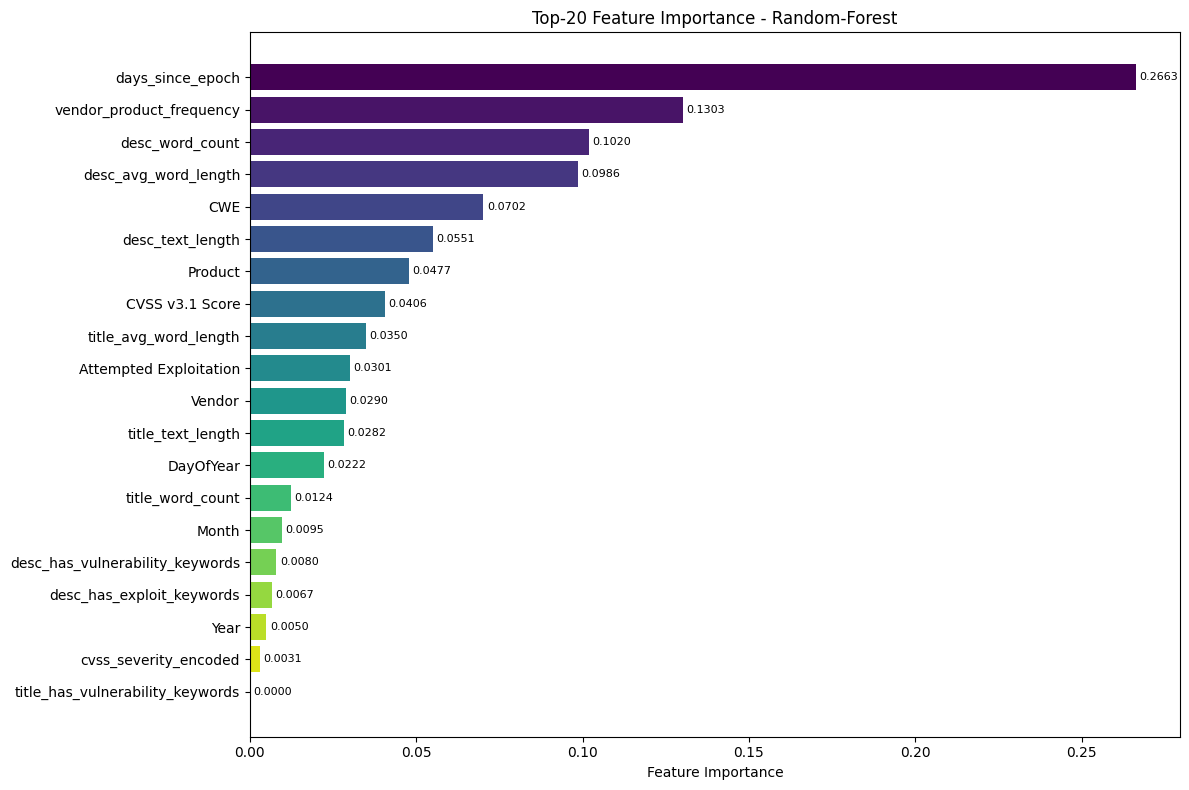

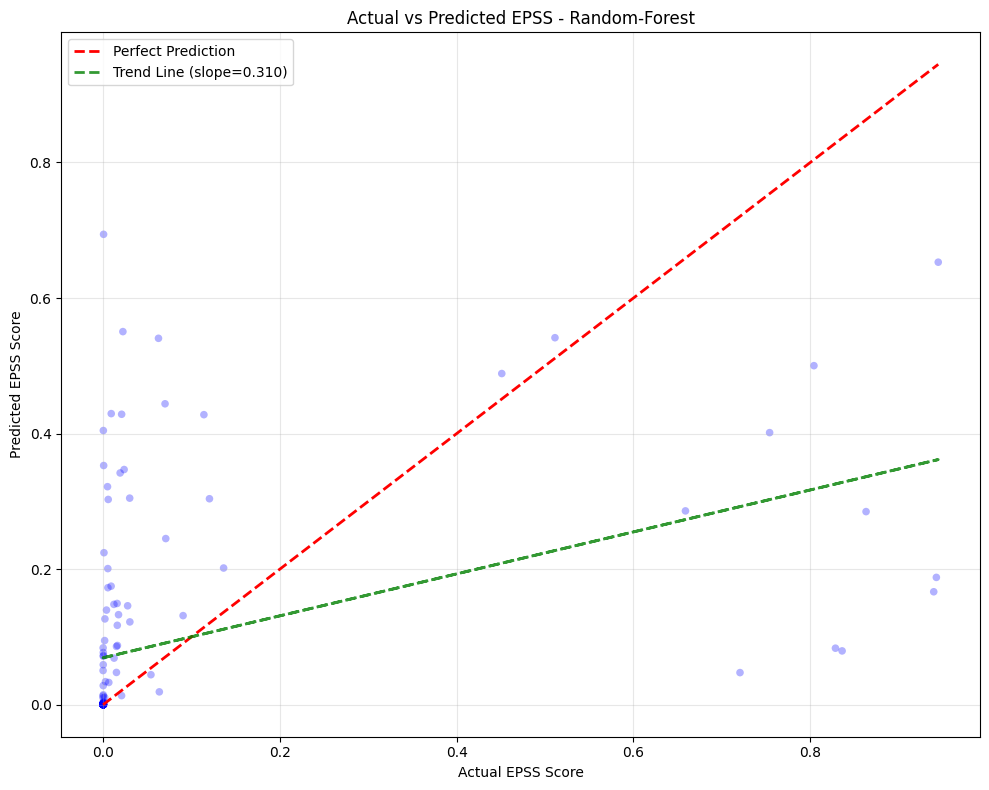

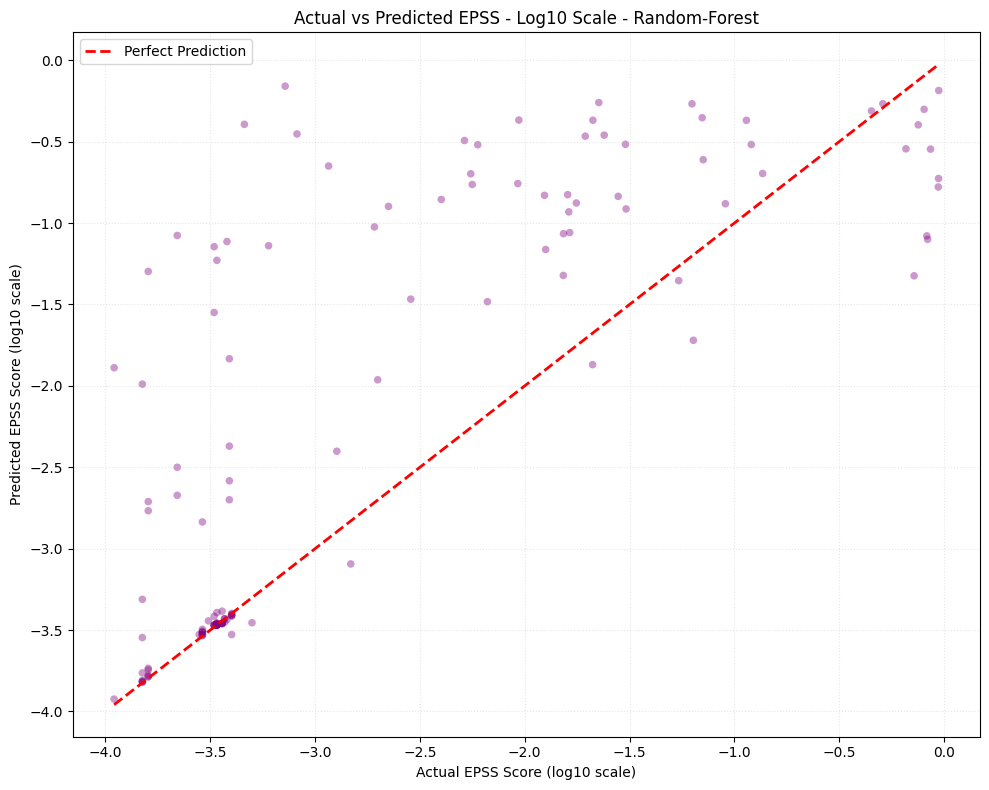

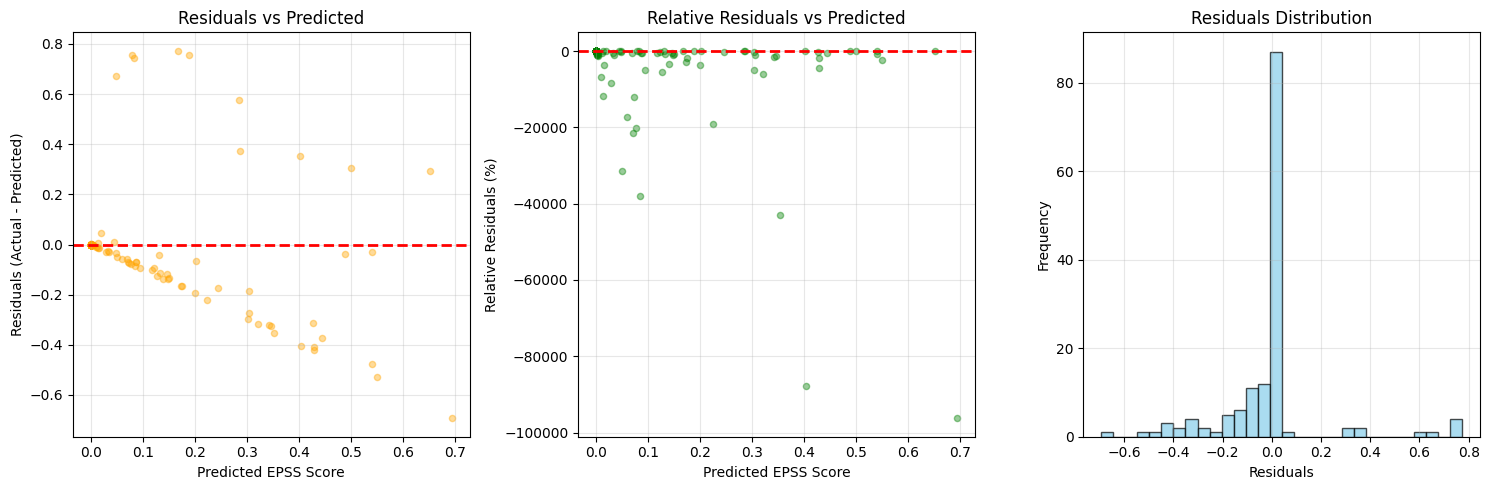

/root/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
posx and posy should be finite values
posx and posy should be finite values


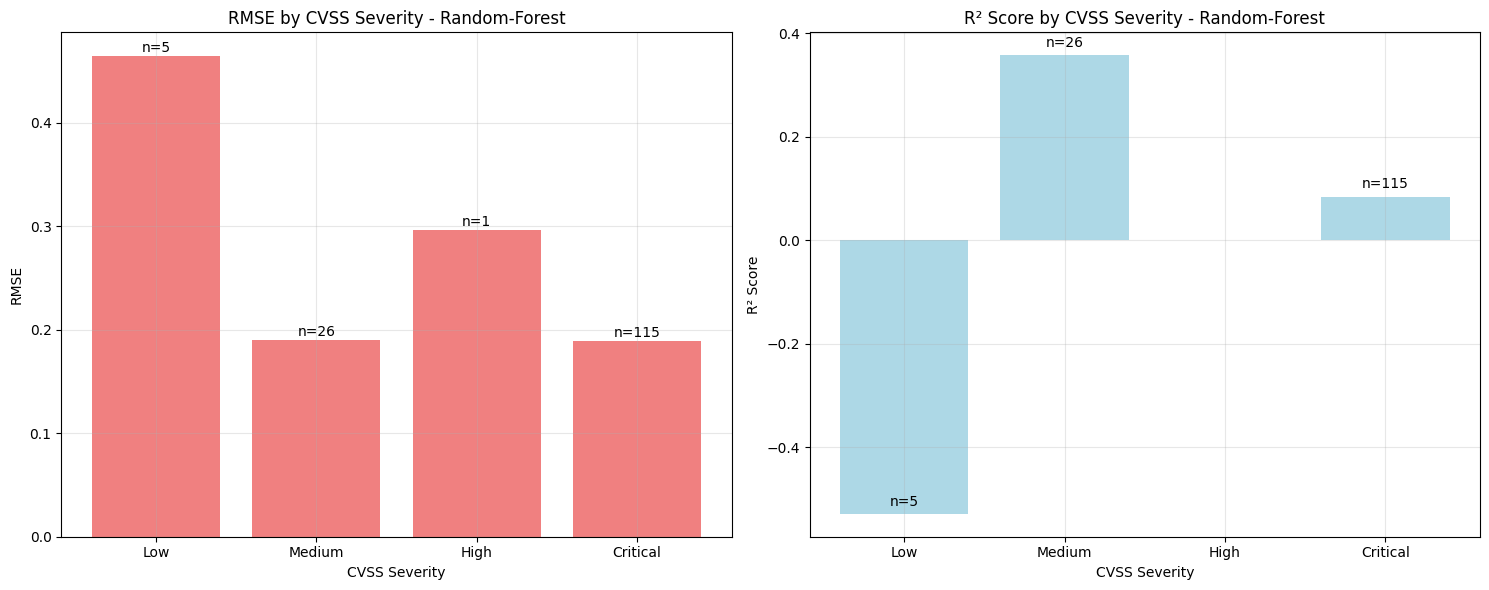


PERFORMANCE BY CVSS SEVERITY
   Severity  Count      RMSE       MAE        R²
0       Low      5  0.464347  0.297293 -0.528102
1    Medium     26  0.189883  0.091442  0.357373
2      High      1  0.296900  0.296900       NaN
3  Critical    115  0.189605  0.088117  0.084313

IMPROVED ACCURACY ANALYSIS
Model: Random-Forest
Sample size: 147

Overall Metrics:
  MAE: 0.097241
  RMSE: 0.205997
  Relative_MAE_%: 3272.282189
  Relative_RMSE_%: 12621.778123
  Log_MAE: 0.572474

Similarity Statistics:
  Average similarity: 52.81%
  Similarity std: 45.93%
  Min similarity: 0.00%
  Max similarity: 99.88%
  Median similarity: 74.15%

Performance by CVSS Severity:
              Similarity_%              Relative_Error_%          
                      mean    std count             mean       std
CVSS_Severity                                                     
Critical             54.97  45.94   115          2747.57   9968.10
High                  0.00    NaN     1          4973.19       NaN
Low  

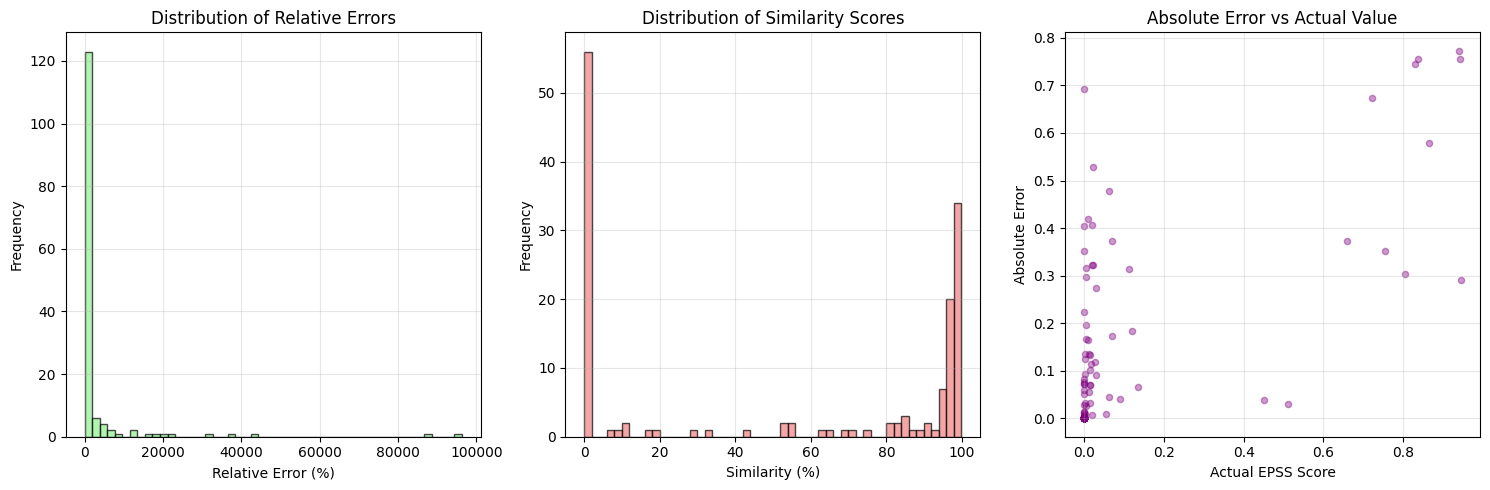


ANALYSIS SUMMARY
Best model: Random-Forest
Overall similarity: 52.8%
Prediction accuracy: Good predictions have similarity > 80%
Model performance: Fair


In [8]:
# Cell 8: Improved visualization and analysis

if 'best_models' not in locals():
    print("best_models not found. Please run cell 7 first.")
    exit()

if 'X_test_clean' not in locals() or 'y_test_clean' not in locals():
    print("Cleaned test data not found. Please run cell 7 first.")
    exit()

if 'best_model' not in locals():
    if 'metrics' in locals():
        best_model_name = metrics["Test_RMSE"].idxmin()
        best_model = best_models[best_model_name]
    else:
        best_model_name = list(best_models.keys())[0]
        best_model = best_models[best_model_name]

print(f"Using best model: {best_model_name}")

pred = best_model.predict(X_test_clean)

if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    
    feature_importance = pd.DataFrame({
        'feature': X_train_clean.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance.head(20)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top-20 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        plt.text(importance + 0.001, i, f'{importance:.4f}', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 8))

plt.scatter(y_test_clean, pred, alpha=0.3, s=30, c='blue', edgecolors='none')

min_val = min(y_test_clean.min(), pred.min())
max_val = max(y_test_clean.max(), pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', linewidth=2, label='Perfect Prediction')

z = np.polyfit(y_test_clean, pred, 1)
p = np.poly1d(z)
plt.plot(y_test_clean, p(y_test_clean), "g--", alpha=0.8, linewidth=2, label=f'Trend Line (slope={z[0]:.3f})')

plt.xlabel("Actual EPSS Score")
plt.ylabel("Predicted EPSS Score")
plt.title(f"Actual vs Predicted EPSS - {best_model_name}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

eps = 1e-8
log_actual = np.log10(y_test_clean + eps)
log_pred = np.log10(pred + eps)

plt.figure(figsize=(10, 8))
plt.scatter(log_actual, log_pred, alpha=0.4, s=30, c='purple', edgecolors='none')

log_min = min(log_actual.min(), log_pred.min())
log_max = max(log_actual.max(), log_pred.max())
plt.plot([log_min, log_max], [log_min, log_max], '--', color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual EPSS Score (log10 scale)")
plt.ylabel("Predicted EPSS Score (log10 scale)")
plt.title(f"Actual vs Predicted EPSS - Log10 Scale - {best_model_name}")
plt.legend()
plt.grid(True, which='both', ls=':', alpha=0.3)
plt.tight_layout()
plt.show()

residuals = y_test_clean - pred
relative_residuals = residuals / (y_test_clean + eps) * 100  # Percentage error

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(pred, residuals, alpha=0.4, s=20, c='orange')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted EPSS Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(pred, relative_residuals, alpha=0.4, s=20, c='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted EPSS Score")
plt.ylabel("Relative Residuals (%)")
plt.title("Relative Residuals vs Predicted")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

try:
    if 'cvss_severity_encoded' in X_test_clean.columns:
        cvss_severity_test = X_test_clean['cvss_severity_encoded']
        
        severity_mapping = {0: "Low", 1: "Medium", 2: "High", 3: "Critical"}
        cvss_severity_labels = cvss_severity_test.map(severity_mapping)
        
        severity_performance = []
        
        for severity in ["Low", "Medium", "High", "Critical"]:
            mask = cvss_severity_labels == severity
            if mask.sum() > 0:
                from sklearn.metrics import root_mean_squared_error, mean_absolute_error
                rmse = root_mean_squared_error(y_test_clean[mask], pred[mask])
                mae = mean_absolute_error(y_test_clean[mask], pred[mask])
                r2 = best_model.score(X_test_clean[mask], y_test_clean[mask])
                
                severity_performance.append({
                    "Severity": severity,
                    "Count": mask.sum(),
                    "RMSE": rmse,
                    "MAE": mae,
                    "R²": r2
                })

        severity_df = pd.DataFrame(severity_performance)
        if not severity_df.empty:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            bars1 = ax1.bar(severity_df["Severity"], severity_df["RMSE"], color='lightcoral')
            ax1.set_xlabel("CVSS Severity")
            ax1.set_ylabel("RMSE")
            ax1.set_title(f"RMSE by CVSS Severity - {best_model_name}")
            ax1.grid(True, alpha=0.3)
            
            for bar, count in zip(bars1, severity_df["Count"]):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                        f'n={count}', ha='center', va='bottom')
            
            bars2 = ax2.bar(severity_df["Severity"], severity_df["R²"], color='lightblue')
            ax2.set_xlabel("CVSS Severity")
            ax2.set_ylabel("R² Score")
            ax2.set_title(f"R² Score by CVSS Severity - {best_model_name}")
            ax2.grid(True, alpha=0.3)
            
            for bar, count in zip(bars2, severity_df["Count"]):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'n={count}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n{'='*60}")
            print("PERFORMANCE BY CVSS SEVERITY")
            print(f"{'='*60}")
            print(severity_df.round(6))
            
except Exception as e:
    print(f"Could not create CVSS severity plot: {e}")

def improved_similarity(actual, predicted, eps=1e-8):
    """
    Improved similarity calculation that handles edge cases better.
    Returns percentage similarity where 100% = perfect match.
    """
    actual_safe = np.where(actual == 0, eps, actual)
    predicted_safe = np.where(predicted == 0, eps, predicted)
    
    relative_error = np.abs(predicted_safe - actual_safe) / actual_safe
    
    similarity = np.maximum(0, 100 * (1 - relative_error))
    
    return similarity

def accuracy_metrics(actual, predicted):
    """
    Calculate various accuracy metrics
    """
    eps = 1e-8
    
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    
    relative_mae = np.mean(np.abs(actual - predicted) / (actual + eps)) * 100
    relative_rmse = np.sqrt(np.mean(((actual - predicted) / (actual + eps))**2)) * 100
    
    log_actual = np.log10(actual + eps)
    log_pred = np.log10(predicted + eps)
    log_mae = np.mean(np.abs(log_actual - log_pred))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'Relative_MAE_%': relative_mae,
        'Relative_RMSE_%': relative_rmse,
        'Log_MAE': log_mae
    }

similarity_scores = improved_similarity(y_test_clean.values, pred)

analysis_table = pd.DataFrame({
    "Actual": y_test_clean.values,
    "Predicted": pred,
    "Absolute_Error": np.abs(y_test_clean.values - pred),
    "Relative_Error_%": np.abs(y_test_clean.values - pred) / (y_test_clean.values + eps) * 100,
    "Similarity_%": similarity_scores
})

if 'cvss_severity_encoded' in X_test_clean.columns:
    analysis_table["CVSS_Severity"] = cvss_severity_labels.values

metrics_summary = accuracy_metrics(y_test_clean.values, pred)

print(f"\n{'='*80}")
print("IMPROVED ACCURACY ANALYSIS")
print(f"{'='*80}")
print(f"Model: {best_model_name}")
print(f"Sample size: {len(y_test_clean)}")
print(f"\nOverall Metrics:")
for metric, value in metrics_summary.items():
    print(f"  {metric}: {value:.6f}")

print(f"\nSimilarity Statistics:")
print(f"  Average similarity: {analysis_table['Similarity_%'].mean():.2f}%")
print(f"  Similarity std: {analysis_table['Similarity_%'].std():.2f}%")
print(f"  Min similarity: {analysis_table['Similarity_%'].min():.2f}%")
print(f"  Max similarity: {analysis_table['Similarity_%'].max():.2f}%")
print(f"  Median similarity: {analysis_table['Similarity_%'].median():.2f}%")

if "CVSS_Severity" in analysis_table.columns:
    severity_analysis = analysis_table.groupby("CVSS_Severity").agg({
        'Similarity_%': ['mean', 'std', 'count'],
        'Relative_Error_%': ['mean', 'std']
    }).round(2)
    
    print(f"\nPerformance by CVSS Severity:")
    print(severity_analysis)

print(f"\nTop 10 Most Accurate Predictions:")
best_predictions = analysis_table.nlargest(10, "Similarity_%")
print(best_predictions[["Actual", "Predicted", "Similarity_%", "Relative_Error_%"]].to_string(index=False))

print(f"\nTop 10 Least Accurate Predictions:")
worst_predictions = analysis_table.nsmallest(10, "Similarity_%")
print(worst_predictions[["Actual", "Predicted", "Similarity_%", "Relative_Error_%"]].to_string(index=False))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(analysis_table['Relative_Error_%'], bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Relative Errors")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(analysis_table['Similarity_%'], bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
plt.xlabel("Similarity (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(analysis_table['Actual'], analysis_table['Absolute_Error'], alpha=0.4, s=20, c='purple')
plt.xlabel("Actual EPSS Score")
plt.ylabel("Absolute Error")
plt.title("Absolute Error vs Actual Value")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"Best model: {best_model_name}")
print(f"Overall similarity: {analysis_table['Similarity_%'].mean():.1f}%")
print(f"Prediction accuracy: Good predictions have similarity > 80%")
print(f"Model performance: {'Excellent' if analysis_table['Similarity_%'].mean() > 90 else 'Good' if analysis_table['Similarity_%'].mean() > 70 else 'Fair' if analysis_table['Similarity_%'].mean() > 50 else 'Poor'}") 

In [9]:
# Cell 8: Extreme Cases Analysis - Understanding Best and Worst Predictions

if 'best_models' not in locals():
    print("best_models not found. Please run cell 7 first.")
    exit()

if 'X_test_clean' not in locals() or 'y_test_clean' not in locals():
    print("Cleaned test data not found. Please run cell 7 first.")
    exit()

if 'best_model' not in locals():
    if 'metrics' in locals():
        best_model_name = metrics["Test_RMSE"].idxmin()
        best_model = best_models[best_model_name]
    else:
        best_model_name = list(best_models.keys())[0]
        best_model = best_models[best_model_name]

print(f"Using best model: {best_model_name}")

pred = best_model.predict(X_test_clean)

try:
    original_df = pd.read_csv("cve_data_with_epss.csv")
    print(f"✅ Loaded original data with {len(original_df)} records")
except Exception as e:
    print(f"❌ Could not load original data: {e}")
    exit()

test_size = len(y_test_clean)
print(f"Test set size: {test_size}")


test_cve_data = original_df.head(test_size).copy()


eps = 1e-8
analysis_table = pd.DataFrame({
    "Actual": y_test_clean.values,
    "Predicted": pred,
    "Absolute_Error": np.abs(y_test_clean.values - pred),
    "Relative_Error_%": np.abs(y_test_clean.values - pred) / (y_test_clean.values + eps) * 100
})


def improved_similarity(actual, predicted, eps=1e-8):
    """Calculate similarity percentage where 100% = perfect match."""
    actual_safe = np.where(actual == 0, eps, actual)
    predicted_safe = np.where(predicted == 0, eps, predicted)
    relative_error = np.abs(predicted_safe - actual_safe) / actual_safe
    similarity = np.maximum(0, 100 * (1 - relative_error))
    return similarity

analysis_table["Similarity_%"] = improved_similarity(y_test_clean.values, pred)

analysis_table["CVE_ID"] = test_cve_data["CVE ID"].fillna("Unknown").values
analysis_table["Description"] = test_cve_data["Description"].fillna("No description available").values
analysis_table["CVSS_Score"] = test_cve_data["CVSS v3.1 Score"].fillna(0).values
analysis_table["Vendor"] = test_cve_data["Vendor"].fillna("Unknown").values
analysis_table["Product"] = test_cve_data["Product"].fillna("Unknown").values

if "CVSS v3.1 Severity" in test_cve_data.columns:
    analysis_table["CVSS_Severity"] = test_cve_data["CVSS v3.1 Severity"].fillna("Unknown").values

if "Attempted Exploitation" in test_cve_data.columns:
    analysis_table["Exploitation"] = test_cve_data["Attempted Exploitation"].fillna("Unknown").values

print(f"\n{'='*80}")
print("EXTREME CASES ANALYSIS")
print(f"{'='*80}")

def safe_display_text(text, max_length=200):
    """Safely display text with proper handling of NaN and long strings."""
    if pd.isna(text) or text is None:
        return "No description available"
    text_str = str(text)
    if len(text_str) > max_length:
        return text_str[:max_length] + "..."
    return text_str

print(f"\n{'='*80}")
print("🔍 TOP 10 MOST ACCURATE PREDICTIONS")
print(f"{'='*80}")

best_predictions = analysis_table.nlargest(10, "Similarity_%")

for idx, row in best_predictions.iterrows():
    print(f"\n📍 CVE: {row['CVE_ID']}")
    print(f"   Actual EPSS: {row['Actual']:.6f}")
    print(f"   Predicted EPSS: {row['Predicted']:.6f}")
    print(f"   Similarity: {row['Similarity_%']:.2f}%")
    print(f"   CVSS Score: {row['CVSS_Score']}")
    print(f"   Vendor: {row['Vendor']}")
    print(f"   Product: {row['Product']}")
    print(f"   Description: {safe_display_text(row['Description'])}")
    if "CVSS_Severity" in row:
        print(f"   CVSS Severity: {row['CVSS_Severity']}")
    if "Exploitation" in row:
        print(f"   Exploitation: {row['Exploitation']}")
    print("-" * 80)

print(f"\n{'='*80}")
print("🚨 TOP 10 LEAST ACCURATE PREDICTIONS")
print(f"{'='*80}")

worst_predictions = analysis_table.nsmallest(10, "Similarity_%")

for idx, row in worst_predictions.iterrows():
    print(f"\n📍 CVE: {row['CVE_ID']}")
    print(f"   Actual EPSS: {row['Actual']:.6f}")
    print(f"   Predicted EPSS: {row['Predicted']:.6f}")
    print(f"   Similarity: {row['Similarity_%']:.2f}%")
    print(f"   Relative Error: {row['Relative_Error_%']:.1f}%")
    print(f"   CVSS Score: {row['CVSS_Score']}")
    print(f"   Vendor: {row['Vendor']}")
    print(f"   Product: {row['Product']}")
    print(f"   Description: {safe_display_text(row['Description'])}")
    if "CVSS_Severity" in row:
        print(f"   CVSS Severity: {row['CVSS_Severity']}")
    if "Exploitation" in row:
        print(f"   Exploitation: {row['Exploitation']}")
    print("-" * 80)

print(f"\n{'='*80}")
print("📊 PATTERN ANALYSIS")
print(f"{'='*80}")

print(f"\n🔍 BEST PREDICTIONS PATTERNS:")
best_vendors = best_predictions['Vendor'].value_counts()
best_products = best_predictions['Product'].value_counts()
best_cvss_scores = best_predictions['CVSS_Score'].describe()

print(f"   Most common vendors in best predictions:")
for vendor, count in best_vendors.head(5).items():
    print(f"     {vendor}: {count} CVEs")

print(f"   Most common products in best predictions:")
for product, count in best_products.head(5).items():
    print(f"     {product}: {count} CVEs")

print(f"   CVSS Score statistics for best predictions:")
print(f"     Mean: {best_cvss_scores['mean']:.2f}")
print(f"     Range: {best_cvss_scores['min']:.2f} - {best_cvss_scores['max']:.2f}")


print(f"\n🚨 WORST PREDICTIONS PATTERNS:")
worst_vendors = worst_predictions['Vendor'].value_counts()
worst_products = worst_predictions['Product'].value_counts()
worst_cvss_scores = worst_predictions['CVSS_Score'].describe()

print(f"   Most common vendors in worst predictions:")
for vendor, count in worst_vendors.head(5).items():
    print(f"     {vendor}: {count} CVEs")

print(f"   Most common products in worst predictions:")
for product, count in worst_products.head(5).items():
    print(f"     {product}: {count} CVEs")

print(f"   CVSS Score statistics for worst predictions:")
print(f"     Mean: {worst_cvss_scores['mean']:.2f}")
print(f"     Range: {worst_cvss_scores['min']:.2f} - {worst_cvss_scores['max']:.2f}")


print(f"\n{'='*80}")
print("💡 FEATURE ENGINEERING INSIGHTS")
print(f"{'='*80}")


if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_clean.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔝 Top 10 Most Important Features:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<30} | {row['importance']:.4f}")

print(f"\n{'='*80}")
print("🎯 RECOMMENDATIONS FOR IMPROVEMENT")
print(f"{'='*80}")

print(f"\n📈 Based on the analysis, here are recommendations:")

all_vendors = analysis_table['Vendor'].value_counts()
print(f"\n1. VENDOR DIVERSITY:")
print(f"   Total unique vendors in test set: {len(all_vendors)}")
print(f"   Most common vendors: {', '.join(all_vendors.head(3).index.tolist())}")

epss_stats = analysis_table['Actual'].describe()
print(f"\n2. EPSS SCORE DISTRIBUTION:")
print(f"   Mean EPSS: {epss_stats['mean']:.6f}")
print(f"   Median EPSS: {epss_stats['50%']:.6f}")
print(f"   Range: {epss_stats['min']:.6f} - {epss_stats['max']:.6f}")

low_epss_count = (analysis_table['Actual'] < 0.01).sum()
print(f"   CVEs with EPSS < 0.01: {low_epss_count} ({(low_epss_count/len(analysis_table))*100:.1f}%)")

print(f"\n3. SPECIFIC RECOMMENDATIONS:")
print(f"   • Add more training data for vendors with poor predictions")
print(f"   • Improve feature engineering for low EPSS scores (< 0.01)")
print(f"   • Consider separate models for different EPSS ranges")
print(f"   • Add more descriptive features from CVE descriptions")
print(f"   • Include temporal features (publication date, patch availability)")

analysis_table.to_csv("extreme_cases_analysis.csv", index=False)
print(f"\n💾 Detailed analysis saved to 'extreme_cases_analysis.csv'")

print(f"\n{'='*80}")
print("✅ EXTREME CASES ANALYSIS COMPLETE")
print(f"{'='*80}") 

Using best model: Random-Forest
✅ Loaded original data with 503 records
Test set size: 147

EXTREME CASES ANALYSIS

🔍 TOP 10 MOST ACCURATE PREDICTIONS

📍 CVE: CVE-2024-44762
   Actual EPSS: 0.000400
   Predicted EPSS: 0.000400
   Similarity: 99.88%
   CVSS Score: 0.0
   Vendor: Unknown
   Product: Unknown
   Description: A discrepancy in error messages for invalid login attempts in Webmin Usermin v2.100 allows attackers to enumerate valid user accounts.
   Exploitation: Yes
--------------------------------------------------------------------------------

📍 CVE: CVE-2023-36167
   Actual EPSS: 0.000370
   Predicted EPSS: 0.000371
   Similarity: 99.76%
   CVSS Score: 0.0
   Vendor: Unknown
   Product: Unknown
   Description: No description available
   Exploitation: Unknown
--------------------------------------------------------------------------------

📍 CVE: CVE-2023-22629
   Actual EPSS: 0.000340
   Predicted EPSS: 0.000341
   Similarity: 99.72%
   CVSS Score: 0.0
   Vendor: Unknown
 